## Imports


In [12]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import io
plt.style.use('seaborn-v0_8-whitegrid')

## Carregar Dataset

In [8]:
import kagglehub
theforcecoder_wind_power_forecasting_path = kagglehub.dataset_download('theforcecoder/wind-power-forecasting')

In [9]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/wind-power-forecasting/Turbine_Data.csv


In [33]:
file_path = '/kaggle/input/wind-power-forecasting/Turbine_Data.csv'

df = pd.read_csv(file_path)
print("\nDataFrame carregado com sucesso!")
print("Primeiras 5 linhas do DataFrame:")
print(df.head())
print("\nInformações do DataFrame:")
df.info()

df.rename(columns={
    'Date/Time': 'Time',
    'LV ActivePower (kW)': 'ActivePower',
    'Wind Speed (m/s)': 'WindSpeed',
    'Theoretical_Power_Curve (KWh)': 'TheoreticalPower',
    'Wind Direction (°)': 'WindDirection'
}, inplace=True)



DataFrame carregado com sucesso!
Primeiras 5 linhas do DataFrame:
                  Unnamed: 0  ActivePower  AmbientTemperatue  BearingShaftTemperature  Blade1PitchAngle  Blade2PitchAngle  Blade3PitchAngle  ControlBoxTemperature  GearboxBearingTemperature  GearboxOilTemperature  GeneratorRPM  GeneratorWinding1Temperature  GeneratorWinding2Temperature  HubTemperature  MainBoxTemperature  NacellePosition  ReactivePower  RotorRPM  TurbineStatus  WTG  WindDirection  WindSpeed
0  2017-12-31 00:00:00+00:00          NaN                NaN                      NaN               NaN               NaN               NaN                    NaN                        NaN                    NaN           NaN                           NaN                           NaN             NaN                 NaN              NaN            NaN       NaN            NaN  G01            NaN        NaN
1  2017-12-31 00:10:00+00:00          NaN                NaN                      NaN               NaN        

## Pré-processamento e Engenharia de Features


In [34]:
print("Coluna de tempo original ('Unnamed: 0'):")
print(df['Unnamed: 0'].head())

df['Time'] = pd.to_datetime(df['Unnamed: 0'])

df = df.set_index('Time')
print("\nDataFrame com 'Time' como índice:")
print(df.head())

# Verificar valores ausentes
print(f"\nValores ausentes por coluna antes do tratamento de NaNs:\n{df.isnull().sum()}")

df.ffill(inplace=True) # Preenche NaNs com o valor anterior válido
df.bfill(inplace=True) # Preenche NaNs restantes (no início do DF) com o valor seguinte válido

print(f"\nValores ausentes por coluna após ffill e bfill:\n{df.isnull().sum()}")

cols_com_nan_restante = df.columns[df.isnull().any()].tolist()
if cols_com_nan_restante:
    print(f"Colunas ainda com NaNs: {cols_com_nan_restante}. Preenchendo com 0.")
    for col in cols_com_nan_restante:
        if df[col].dtype == 'float64' or df[col].dtype == 'int64':
            df[col].fillna(0, inplace=True) # Ou df[col].fillna(df[col].mean(), inplace=True)

print(f"\nValores ausentes por coluna após tratamento final de NaNs:\n{df.isnull().sum()}")

df['hour'] = df.index.hour
df['dayofweek'] = df.index.dayofweek # Segunda=0, Domingo=6
df['quarter'] = df.index.quarter
df['month'] = df.index.month
df['year'] = df.index.year
df['dayofyear'] = df.index.dayofyear
df['dayofmonth'] = df.index.day
df['weekofyear'] = df.index.isocalendar().week.astype(int)

print("\nDataFrame com novas features de tempo:")
print(df.head())
df.info()

Coluna de tempo original ('Unnamed: 0'):
0    2017-12-31 00:00:00+00:00
1    2017-12-31 00:10:00+00:00
2    2017-12-31 00:20:00+00:00
3    2017-12-31 00:30:00+00:00
4    2017-12-31 00:40:00+00:00
Name: Unnamed: 0, dtype: object

DataFrame com 'Time' como índice:
                                          Unnamed: 0  ActivePower  AmbientTemperatue  BearingShaftTemperature  Blade1PitchAngle  Blade2PitchAngle  Blade3PitchAngle  ControlBoxTemperature  GearboxBearingTemperature  GearboxOilTemperature  GeneratorRPM  GeneratorWinding1Temperature  GeneratorWinding2Temperature  HubTemperature  MainBoxTemperature  NacellePosition  ReactivePower  RotorRPM  TurbineStatus  WTG  WindDirection  WindSpeed
Time                                                                                                                                                                                                                                                                                                          

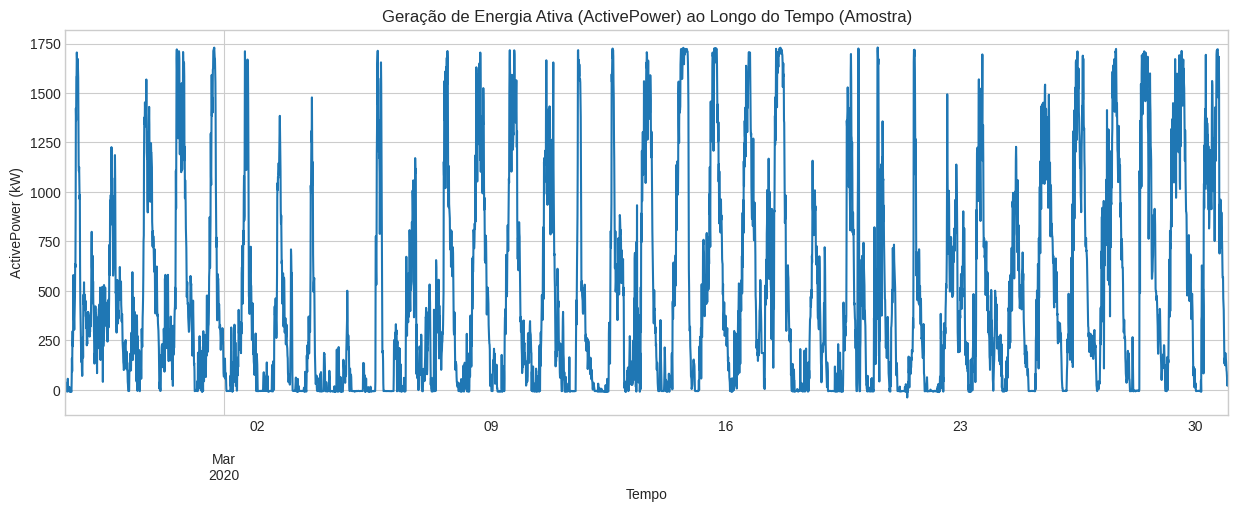

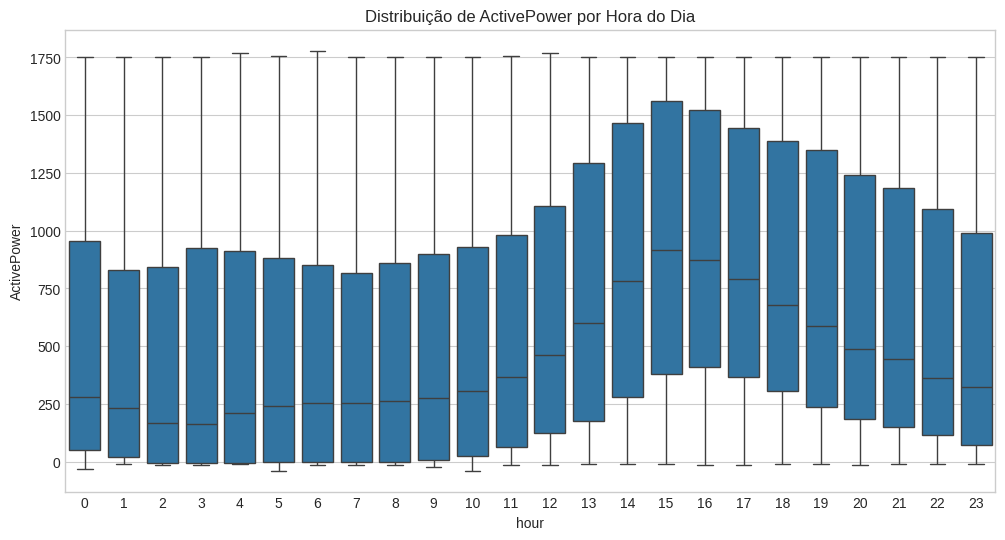

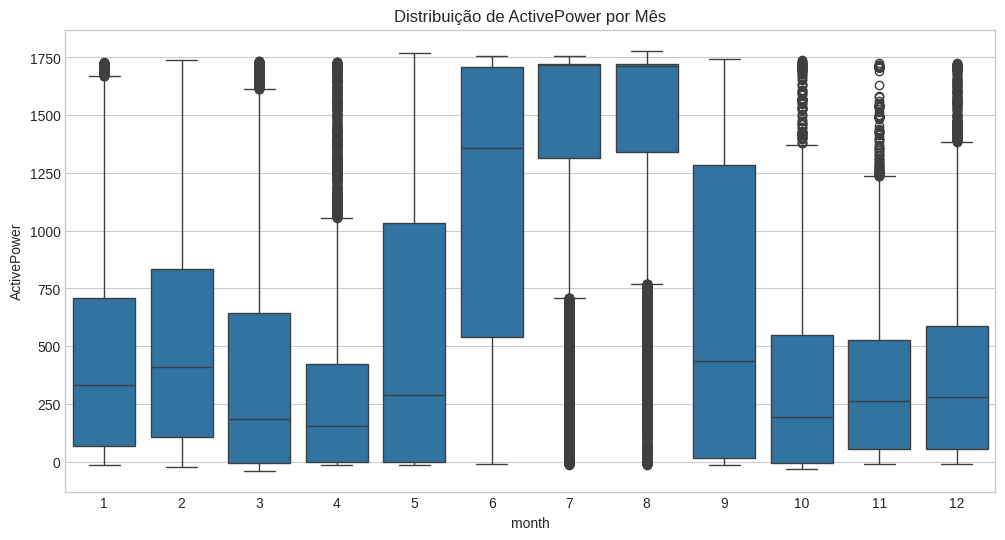

In [16]:
plt.figure(figsize=(15, 5))
plot_data = df['ActivePower'].tail(5000) if len(df) > 5000 else df['ActivePower']
plot_data.plot(title='Geração de Energia Ativa (ActivePower) ao Longo do Tempo (Amostra)')
plt.ylabel('ActivePower (kW)')
plt.xlabel('Tempo')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='hour', y='ActivePower')
plt.title('Distribuição de ActivePower por Hora do Dia')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='month', y='ActivePower')
plt.title('Distribuição de ActivePower por Mês')
plt.show()

In [18]:
FEATURES = [
    'hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear', 'dayofmonth', 'weekofyear',
    'WindSpeed',
    'WindDirection',
    'AmbientTemperatue',
    'GeneratorRPM',
    'NacellePosition',
    'BearingShaftTemperature',
    'Blade1PitchAngle',
]
TARGET = 'ActivePower'

df_filtered = df[df['ActivePower'] > 0].copy()

# Verificação importante: Garantir que todas as FEATURES selecionadas existem em df_filtered
missing_features = [feature for feature in FEATURES if feature not in df_filtered.columns]
if missing_features:
    print(f"ATENÇÃO: As seguintes features estão na lista FEATURES mas não no DataFrame: {missing_features}")
    print("Por favor, corrija a lista FEATURES ou verifique os nomes das colunas no DataFrame.")
    FEATURES = [feature for feature in FEATURES if feature in df_filtered.columns]
    print(f"Lista FEATURES atualizada: {FEATURES}")

if df_filtered.empty:
    print("Atenção: Nenhum dado restou após filtrar ActivePower > 0. Verifique seus dados.")
    X = df[FEATURES].copy()
    y = df[TARGET].copy()
else:
    X = df_filtered[FEATURES].copy() # Esta linha estava causando o erro
    y = df_filtered[TARGET].copy()


print("\nFeatures (X):")
print(X.head())
print("\nTarget (y):")
print(y.head())


Features (X):
                           hour  dayofweek  quarter  month  year  dayofyear  \
Time                                                                          
2018-01-01 06:20:00+00:00     6          0        1      1  2018          1   
2018-01-01 06:40:00+00:00     6          0        1      1  2018          1   
2018-01-01 06:50:00+00:00     6          0        1      1  2018          1   
2018-01-01 10:40:00+00:00    10          0        1      1  2018          1   
2018-01-01 12:00:00+00:00    12          0        1      1  2018          1   

                           dayofmonth  weekofyear  WindSpeed  WindDirection  \
Time                                                                          
2018-01-01 06:20:00+00:00           1           1   3.042750         252.00   
2018-01-01 06:40:00+00:00           1           1   3.424814         255.00   
2018-01-01 06:50:00+00:00           1           1   3.507172         264.75   
2018-01-01 10:40:00+00:00           

In [19]:
split_fraction = 0.8
if len(X) < 50:
    print("Dataset muito pequeno, ajustando split para usar mais dados para treino.")
    split_fraction = 0.7

if len(X) == 0:
    raise ValueError("Não há dados em X para dividir. Verifique os passos anteriores.")

split_point = int(len(X) * split_fraction)

X_train = X.iloc[:split_point]
y_train = y.iloc[:split_point]
X_test = X.iloc[split_point:]
y_test = y.iloc[split_point:]


print(f"\nTamanho do conjunto de treino: {X_train.shape[0]} amostras (Índice de {X_train.index.min()} a {X_train.index.max()})")
print(f"Tamanho do conjunto de teste: {X_test.shape[0]} amostras (Índice de {X_test.index.min()} a {X_test.index.max()})")

if X_test.empty or y_test.empty:
    print("Conjunto de teste está vazio. Ajuste a lógica de divisão ou verifique a quantidade de dados.")



Tamanho do conjunto de treino: 76600 amostras (Índice de 2018-01-01 06:20:00+00:00 a 2019-10-15 17:20:00+00:00)
Tamanho do conjunto de teste: 19150 amostras (Índice de 2019-10-15 20:30:00+00:00 a 2020-03-30 23:50:00+00:00)


## Treinamento do Modelo

In [22]:
reg = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1, # Taxa de aprendizado menor geralmente requer mais árvores
    random_state=42,
    max_depth=6,
)

print("\nTreinando o modelo XGBRegressor...")
if not X_test.empty and not y_test.empty:
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100) # Imprimir progresso a cada 100 iterações
else:
    print("Conjunto de teste vazio ou não disponível para eval_set. Treinando sem early stopping no conjunto de teste.")
    reg.fit(X_train, y_train, verbose=100)

print("\nModelo XGBRegressor treinado.")


Treinando o modelo XGBRegressor...
[0]	validation_0-rmse:566.65512	validation_1-rmse:480.01424
[100]	validation_0-rmse:42.51106	validation_1-rmse:84.16465
[199]	validation_0-rmse:38.00741	validation_1-rmse:86.50584

Modelo XGBRegressor treinado.


# Avaliação do Modelo no Conjunto de Teste - Seção de Plotagem com LINHAS


RMSE: 86.51
MAE: 33.40
MAPE: 12983.48%

Plotando comparação: Valores Reais vs. Previsões no Conjunto de Teste (com linhas)...


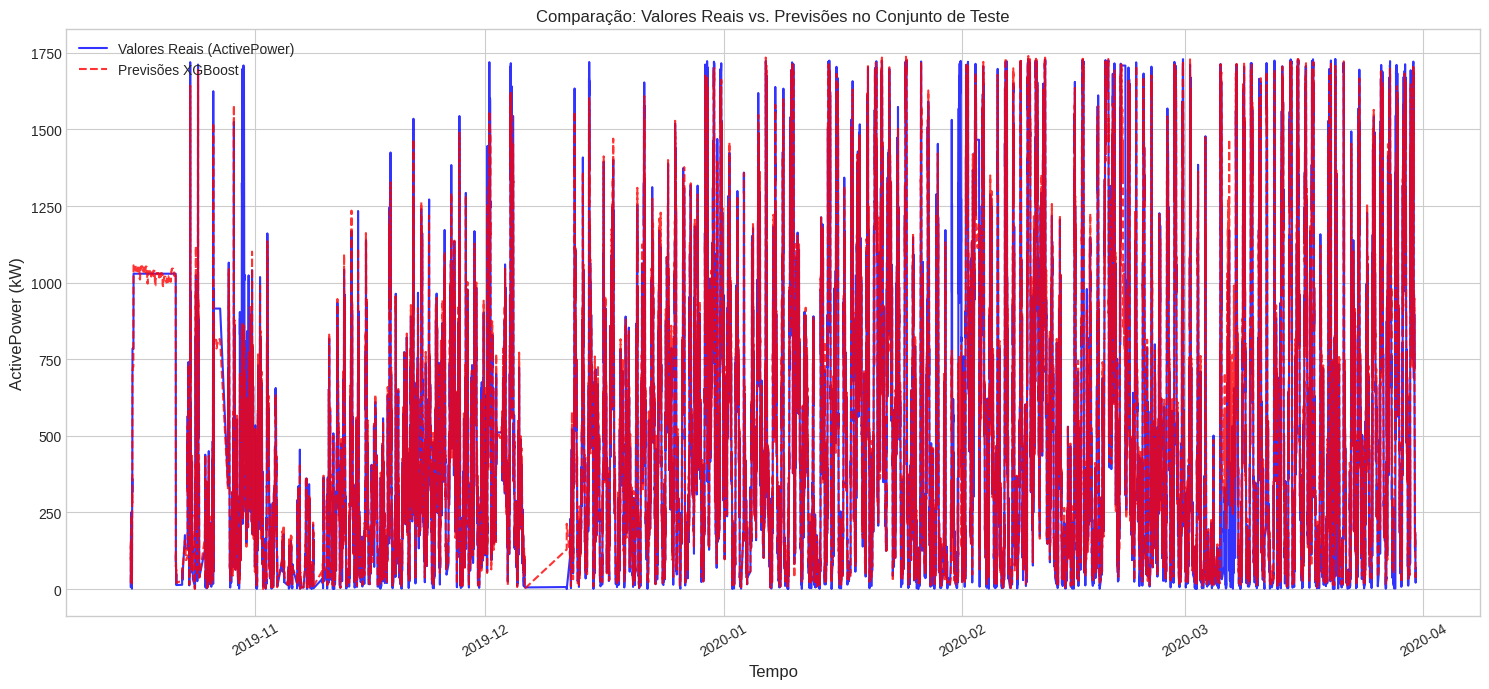

In [31]:
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")

if not X_test.empty and not y_test.empty:
    print("\nPlotando comparação: Valores Reais vs. Previsões no Conjunto de Teste (com linhas)...")
    plt.figure(figsize=(15, 7)) # Ajuste o tamanho se necessário

    y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)

    # Plotando com linhas
    plt.plot(y_test, label="Valores Reais (ActivePower)", color='blue', alpha=0.8)
    plt.plot(y_pred_test_series, label="Previsões XGBoost", color='red', linestyle='--', alpha=0.8)

    plt.title('Comparação: Valores Reais vs. Previsões no Conjunto de Teste')
    plt.ylabel('ActivePower (kW)', fontsize=12)
    plt.xlabel('Tempo', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=30) # Rotaciona os labels do eixo x para melhor visualização
    plt.tight_layout() # Ajusta o plot para evitar sobreposição de labels
    plt.show()
else:
    print("Conjunto de teste vazio, pulando plotagem de teste.")



## Processar para Previsão de Dias Futuros

In [27]:
dias_para_prever = 7
# Inferir a frequência dos dados do índice do DataFrame original, se possível
if df.index.freqstr:
    frequencia_dados = df.index.freqstr
    print(f"Frequência de dados inferida: {frequencia_dados}")
else:
    # Tentar calcular a frequência mais comum se não estiver definida
    time_diffs = np.diff(df.index.values)
    if len(time_diffs) > 0:
        # Encontra a diferença de tempo mais comum (moda)
        most_common_diff = pd.Timedelta(pd.Series(time_diffs).mode()[0])
        frequencia_dados = pd.tseries.frequencies.to_offset(most_common_diff)
        if frequencia_dados:
            print(f"Frequência de dados calculada: {frequencia_dados.freqstr}")
        else:
            frequencia_dados = '10min' # Fallback
            print(f"Não foi possível calcular frequência, usando fallback: {frequencia_dados}")
    else:
        frequencia_dados = '10min' # Fallback se não houver dados suficientes para inferir
        print(f"Não foi possível inferir frequência, usando fallback: {frequencia_dados}")


# Última data no nosso conjunto de dados original (X completo)
if not X.empty:
    ultima_data_conhecida = X.index.max()
else: # Se X estiver vazio por algum motivo, usar o df original
    ultima_data_conhecida = df.index.max()

print(f"Última data conhecida no dataset (X): {ultima_data_conhecida}")

# Criar um range de datas futuras
# Precisamos calcular o número de períodos corretamente
if isinstance(frequencia_dados, str):
    freq_obj = pd.tseries.frequencies.to_offset(frequencia_dados)
else:
    freq_obj = frequencia_dados

# Calcula quantos intervalos da 'frequencia_dados' existem em um dia
try:
    periodos_por_dia = pd.Timedelta(days=1) / freq_obj.delta
except AttributeError: # Se freq_obj for None ou não tiver delta
    print("AVISO: freq_obj.delta não é acessível. Assumindo 144 períodos por dia (10min).")
    periodos_por_dia = 144 # (24 * 6) para 10min


total_periodos_futuros = int(periodos_por_dia * dias_para_prever)

datas_futuras = pd.date_range(
    start=ultima_data_conhecida + freq_obj, # Começa um intervalo após a última data conhecida
    periods=total_periodos_futuros,
    freq=freq_obj
)

df_futuro = pd.DataFrame(index=datas_futuras)
df_futuro['isFuture'] = True

print(f"\nDataFrame futuro criado com {len(df_futuro)} períodos.")
print(f"Primeiras datas futuras para previsão: {df_futuro.head().index}")
print(f"Últimas datas futuras para previsão: {df_futuro.tail().index}")

Frequência de dados calculada: 10min
Última data conhecida no dataset (X): 2020-03-30 23:50:00+00:00

DataFrame futuro criado com 1008 períodos.
Primeiras datas futuras para previsão: DatetimeIndex(['2020-03-31 00:00:00+00:00', '2020-03-31 00:10:00+00:00',
               '2020-03-31 00:20:00+00:00', '2020-03-31 00:30:00+00:00',
               '2020-03-31 00:40:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='10min')
Últimas datas futuras para previsão: DatetimeIndex(['2020-04-06 23:10:00+00:00', '2020-04-06 23:20:00+00:00',
               '2020-04-06 23:30:00+00:00', '2020-04-06 23:40:00+00:00',
               '2020-04-06 23:50:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='10min')


<ipython-input-27-71f89f83c0a8>:41: FutureWarning: Minute.delta is deprecated and will be removed in a future version. Use pd.Timedelta(obj) instead
  periodos_por_dia = pd.Timedelta(days=1) / freq_obj.delta


In [28]:
# Criar as mesmas features baseadas no tempo que usamos para o treino
df_futuro['hour'] = df_futuro.index.hour
df_futuro['dayofweek'] = df_futuro.index.dayofweek
df_futuro['quarter'] = df_futuro.index.quarter
df_futuro['month'] = df_futuro.index.month
df_futuro['year'] = df_futuro.index.year
df_futuro['dayofyear'] = df_futuro.index.dayofyear
df_futuro['dayofmonth'] = df_futuro.index.day
df_futuro['weekofyear'] = df_futuro.index.isocalendar().week.astype(int)


features_para_media = ['WindSpeed', 'TheoreticalPower', 'WindDirection']
present_features_para_media = [f for f in features_para_media if f in df.columns]

if present_features_para_media:
    # Calcular médias por hora e mês para mais granularidade sazonal
    seasonal_avg_features = df[present_features_para_media].groupby([df.index.month, df.index.hour]).mean()

    def get_seasonal_avg_feature(timestamp, feature_name):
        try:
            return seasonal_avg_features.loc[(timestamp.month, timestamp.hour), feature_name]
        except KeyError:
            # Fallback: se a combinação mês/hora específica não existir, usar média geral da feature
            return df[feature_name].mean() if feature_name in df.columns else 0

    for feature in present_features_para_media:
        print(f"Gerando média sazonal para {feature}...")
        df_futuro[feature] = df_futuro.index.map(lambda ts: get_seasonal_avg_feature(ts, feature))
else:
    print("Nenhuma das features ('WindSpeed', 'TheoreticalPower', 'WindDirection') encontrada no DataFrame histórico para calcular médias.")

# Para features que não foram preenchidas (ex: não estavam em present_features_para_media)
for feature in features_para_media:
    if feature not in df_futuro.columns:
        df_futuro[feature] = df[feature].mean() if feature in df.columns else 0 # Média geral ou 0
        print(f"Atenção: Feature '{feature}' preenchida com média geral ou 0 para o futuro.")


for col in FEATURES:
    if col not in df_futuro.columns:
        print(f"Feature '{col}' ausente no df_futuro, preenchendo com 0. Verifique a lógica de criação de features.")
        df_futuro[col] = 0

X_futuro = df_futuro[FEATURES]

print("\nDataFrame futuro com features (X_futuro head):")
print(X_futuro.head())
print("\nVerificação de NaNs em X_futuro:")
print(X_futuro.isnull().sum())
if X_futuro.isnull().values.any():
    print("ATENÇÃO: NaNs encontrados em X_futuro. Preenchendo com a média da coluna do treino.")
    for col in X_futuro.columns[X_futuro.isnull().any()]:
        mean_val = X_train[col].mean() if col in X_train.columns else 0
        X_futuro[col].fillna(mean_val, inplace=True)
    print("NaNs preenchidos em X_futuro.")

Gerando média sazonal para WindSpeed...
Gerando média sazonal para WindDirection...
Atenção: Feature 'TheoreticalPower' preenchida com média geral ou 0 para o futuro.
Feature 'AmbientTemperatue' ausente no df_futuro, preenchendo com 0. Verifique a lógica de criação de features.
Feature 'GeneratorRPM' ausente no df_futuro, preenchendo com 0. Verifique a lógica de criação de features.
Feature 'NacellePosition' ausente no df_futuro, preenchendo com 0. Verifique a lógica de criação de features.
Feature 'BearingShaftTemperature' ausente no df_futuro, preenchendo com 0. Verifique a lógica de criação de features.
Feature 'Blade1PitchAngle' ausente no df_futuro, preenchendo com 0. Verifique a lógica de criação de features.

DataFrame futuro com features (X_futuro head):
                           hour  dayofweek  quarter  month  year  dayofyear  \
2020-03-31 00:00:00+00:00     0          1        1      3  2020         91   
2020-03-31 00:10:00+00:00     0          1        1      3  2020     

## Previisões Futuras

In [29]:
future_predictions = reg.predict(X_futuro)

# Evitar previsões negativas se ActivePower não pode ser negativa
future_predictions = np.maximum(0, future_predictions)

# Adicionar previsões ao DataFrame futuro
df_futuro['Predicted_ActivePower'] = future_predictions

print("\nPrevisões futuras (head):")
print(df_futuro[['Predicted_ActivePower']].head())
print("\nPrevisões futuras (tail):")
print(df_futuro[['Predicted_ActivePower']].tail())


Previsões futuras (head):
                           Predicted_ActivePower
2020-03-31 00:00:00+00:00             237.491058
2020-03-31 00:10:00+00:00             237.491058
2020-03-31 00:20:00+00:00             237.491058
2020-03-31 00:30:00+00:00             237.491058
2020-03-31 00:40:00+00:00             237.491058

Previsões futuras (tail):
                           Predicted_ActivePower
2020-04-06 23:10:00+00:00             352.004395
2020-04-06 23:20:00+00:00             352.004395
2020-04-06 23:30:00+00:00             352.004395
2020-04-06 23:40:00+00:00             352.004395
2020-04-06 23:50:00+00:00             352.004395


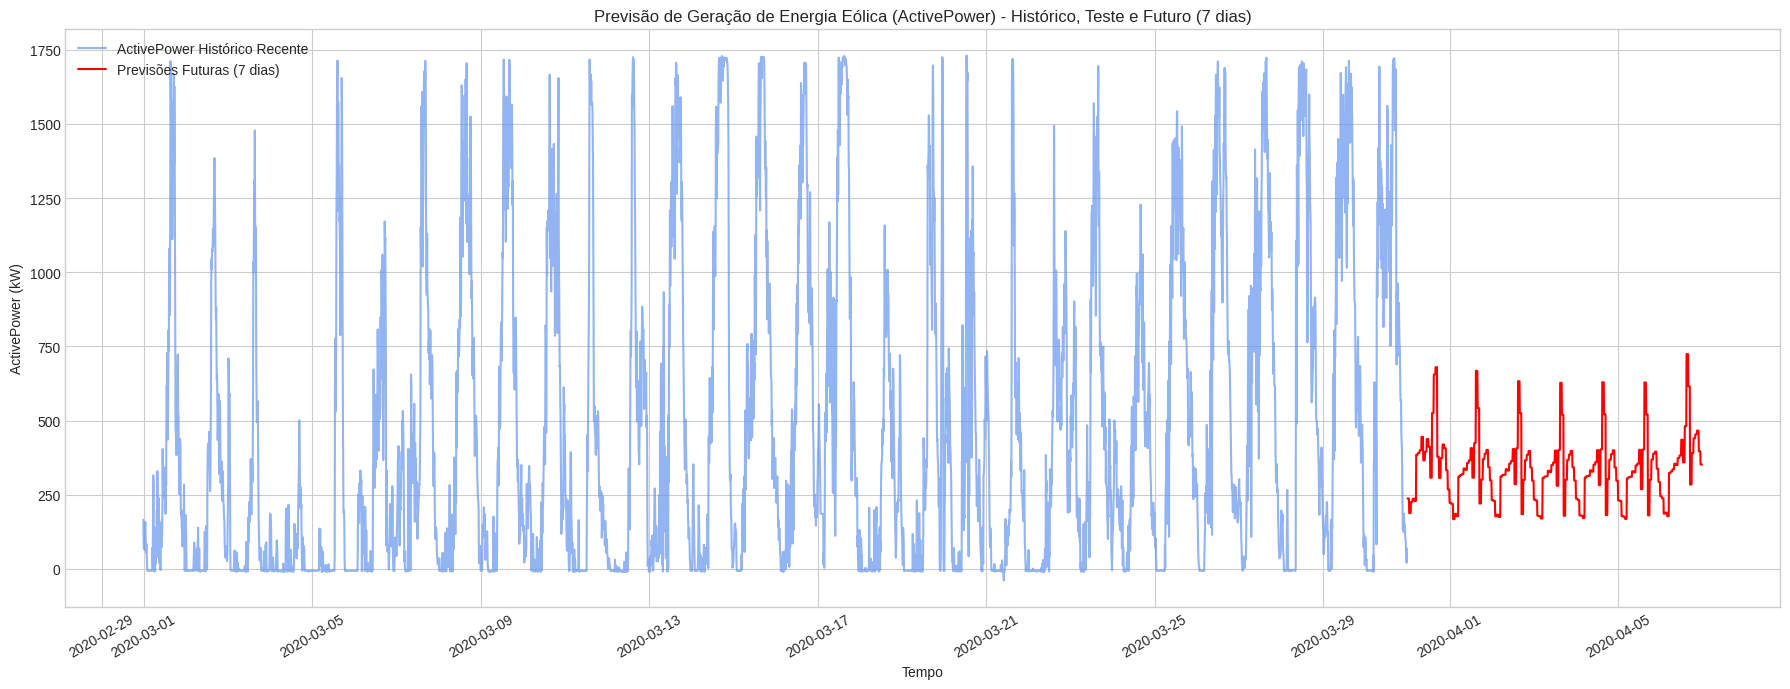

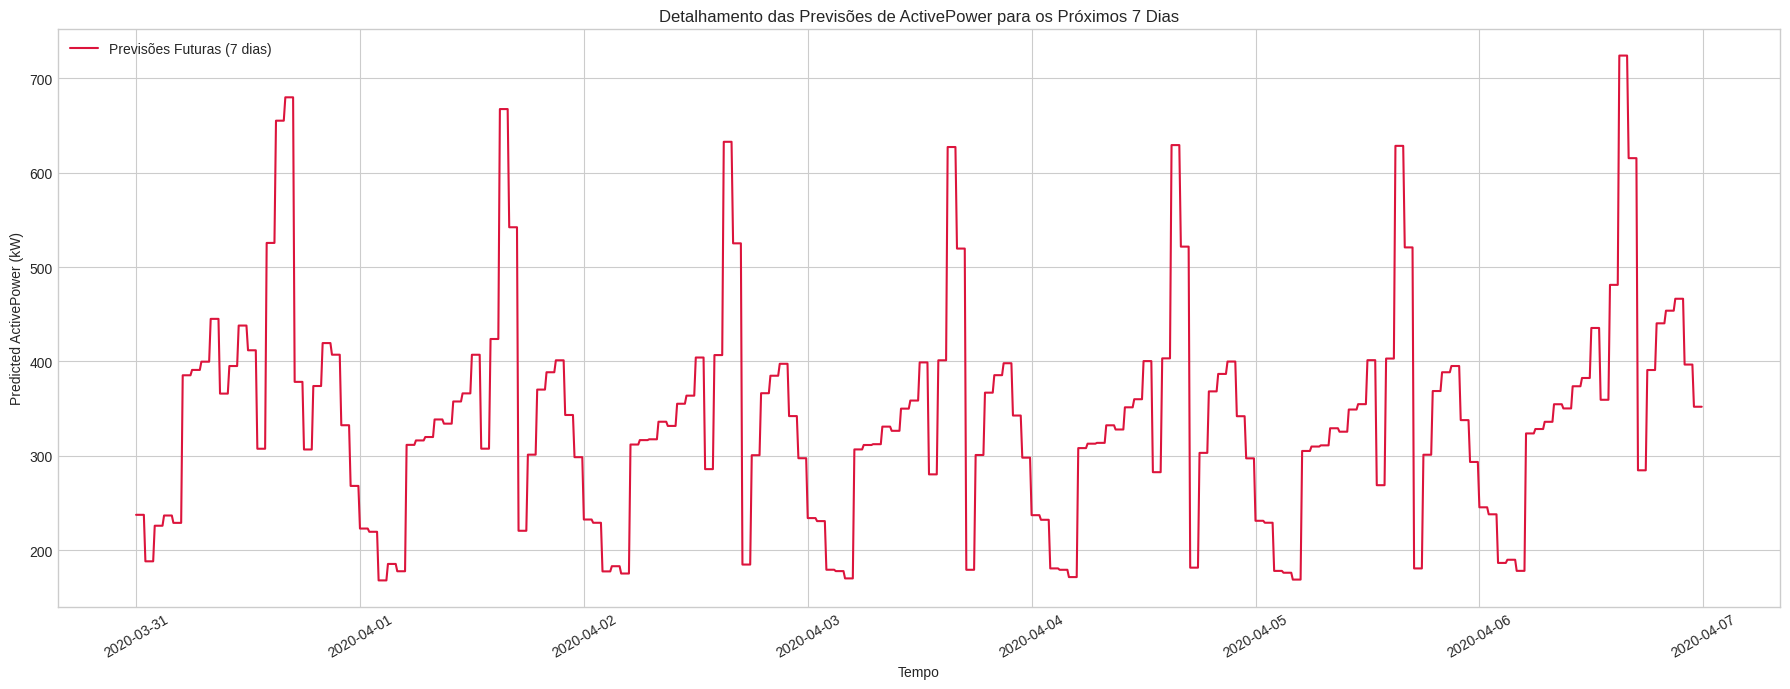

In [30]:
plt.figure(figsize=(18, 7))

dias_historico_plot = 30 # Quantos dias de histórico mostrar no plot
df.index = pd.to_datetime(df.index)
ultima_data_historica_df = df.index.max()

historico_plot_start_date = ultima_data_historica_df - pd.Timedelta(days=dias_historico_plot)
historico_plot = df[df.index >= historico_plot_start_date]['ActivePower']

plt.plot(historico_plot.index, historico_plot, label='ActivePower Histórico Recente', color='cornflowerblue', alpha=0.7)

if not X_test.empty and not y_test.empty:
    y_test_plot = pd.Series(y_test.values, index=X_test.index)
    y_pred_test_plot = pd.Series(y_pred_test, index=X_test.index)

    if y_test_plot.index.min() >= historico_plot_start_date:
         plt.plot(y_test_plot.index, y_pred_test_plot, label='Previsões XGBoost (Teste)', color='darkorange', linestyle='--', alpha=0.8)


# Plotar previsões futuras
plt.plot(df_futuro.index, df_futuro['Predicted_ActivePower'], label=f'Previsões Futuras ({dias_para_prever} dias)', color='red', linestyle='-')

plt.title(f'Previsão de Geração de Energia Eólica (ActivePower) - Histórico, Teste e Futuro ({dias_para_prever} dias)')
plt.xlabel('Tempo')
plt.ylabel('ActivePower (kW)')
plt.legend(loc='upper left')
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

plt.figure(figsize=(18, 7))
plt.plot(df_futuro.index, df_futuro['Predicted_ActivePower'], label=f'Previsões Futuras ({dias_para_prever} dias)', color='crimson')
if len(df_futuro) < 500:
    plt.scatter(df_futuro.index, df_futuro['Predicted_ActivePower'], color='crimson', s=10)

plt.title(f'Detalhamento das Previsões de ActivePower para os Próximos {dias_para_prever} Dias')
plt.xlabel('Tempo')
plt.ylabel('Predicted ActivePower (kW)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()